In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

from data.data_generator import ColorSpace, SkinLesionDataSequence, DatasetType

## Load and Visualize the Data

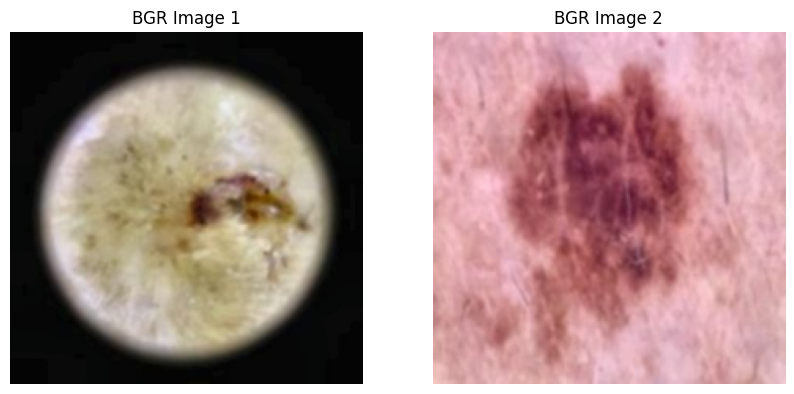

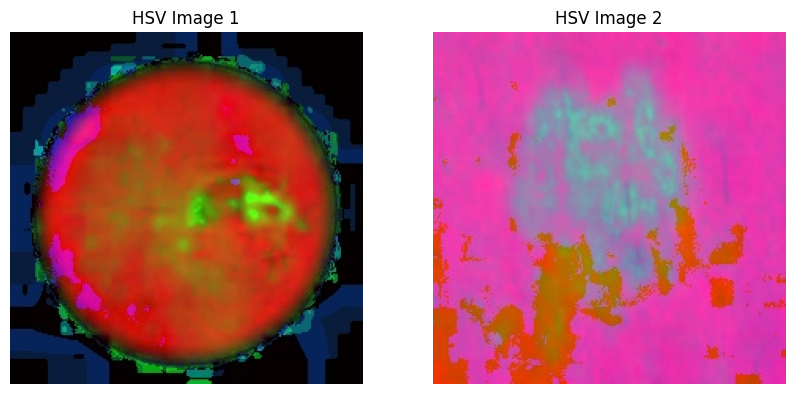

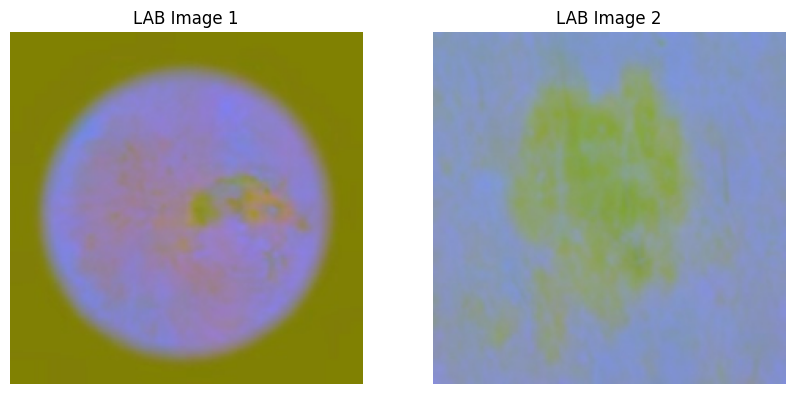

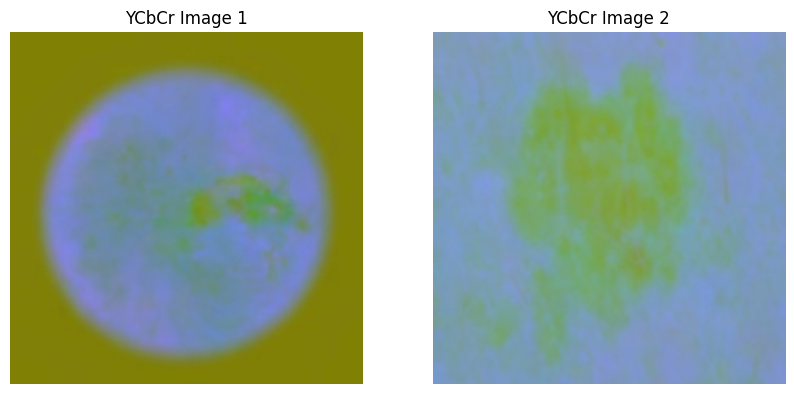

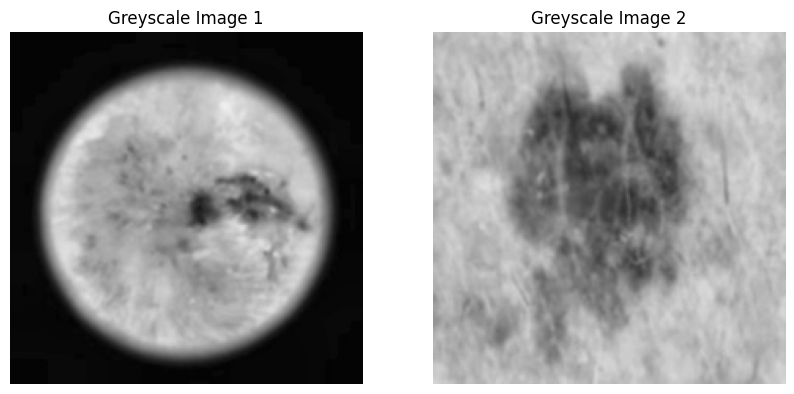

In [2]:
def display_images_for_color_space(color_space):
    data_sequence = SkinLesionDataSequence(base_dir='data', dataset_type=DatasetType.Train, color_space=color_space, batch_size=2, normalize=False)
    
    images, _ = data_sequence[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, img in enumerate(images):
        if color_space != ColorSpace.Greyscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'{color_space.value} Image {i+1}')
    plt.show()

for color_space in ColorSpace:
    display_images_for_color_space(color_space)

## Preprocess the Images

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9324455/

\begin{equation}
I_{\text {norm }}=\left(I-\operatorname{Min}_I\right)\left(\frac{2}{\operatorname{Max}_I-\operatorname{Min}_I}\right)-1
\end{equation}

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

def build_model(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

batch_size = 128
epochs = 10

for color_space in ColorSpace:
    print(f"Training model for {color_space.value} color space...")
    
    input_shape = (224, 224, 3)  
    model = build_model(input_shape=input_shape)
    
    checkpoint_filepath = f'best_model_{color_space.value}.keras'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')
    
    train_sequence = SkinLesionDataSequence(base_dir='data', dataset_type=DatasetType.Train, color_space=color_space, batch_size=batch_size, normalize=True, augment=True)
    val_sequence = SkinLesionDataSequence(base_dir='data', dataset_type=DatasetType.Validation, color_space=color_space, batch_size=batch_size, normalize=True)
    
    # Train the model
    model.fit(train_sequence, epochs=epochs, validation_data=val_sequence, callbacks=[model_checkpoint_callback])
    
    print(f"Best model for {color_space.value} color space saved as {checkpoint_filepath}")


Training model for BGR color space...
Epoch 1/10
279/279 [==============================] - 425s 2s/step - loss: 0.4609 - accuracy: 0.8073 - val_loss: 0.2703 - val_accuracy: 0.8900
Epoch 2/10
279/279 [==============================] - 416s 1s/step - loss: 0.3252 - accuracy: 0.8573 - val_loss: 0.3159 - val_accuracy: 0.8475
Epoch 3/10
279/279 [==============================] - 419s 2s/step - loss: 0.3051 - accuracy: 0.8681 - val_loss: 0.2920 - val_accuracy: 0.8825
Epoch 4/10
279/279 [==============================] - 418s 1s/step - loss: 0.2945 - accuracy: 0.8739 - val_loss: 0.2477 - val_accuracy: 0.8900
Epoch 5/10
279/279 [==============================] - 417s 1s/step - loss: 0.2764 - accuracy: 0.8803 - val_loss: 0.2446 - val_accuracy: 0.8950
Epoch 6/10
279/279 [==============================] - 418s 1s/step - loss: 0.2684 - accuracy: 0.8839 - val_loss: 0.2249 - val_accuracy: 0.9250
Epoch 7/10
279/279 [==============================] - 416s 1s/step - loss: 0.2621 - accuracy: 0.8882 - v

In [10]:
from tensorflow.keras.models import load_model

models = {}
for color_space in ColorSpace:
    model_path = f'best_model_{color_space.value}.keras'
    models[color_space.value] = load_model(model_path)

In [11]:
models

{'BGR': <keras.src.engine.sequential.Sequential at 0x157504d30>,
 'HSV': <keras.src.engine.sequential.Sequential at 0x154aeb9d0>,
 'LAB': <keras.src.engine.sequential.Sequential at 0x156d20a90>,
 'YCbCr': <keras.src.engine.sequential.Sequential at 0x3500bdb70>,
 'Greyscale': <keras.src.engine.sequential.Sequential at 0x157225720>}

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
metrics_list = []

threshold = 0.5
individual_preds = {}
for color_space, model in models.items():
    test_sequence = SkinLesionDataSequence(base_dir='data', dataset_type=DatasetType.Test, color_space=ColorSpace(color_space), batch_size=batch_size, normalize=True)
    true_labels = test_sequence.labels
    preds = model.predict(test_sequence)
    individual_preds[color_space] = (preds > threshold).astype(int)

    # Calculate metrics for individual model
    acc = accuracy_score(true_labels, individual_preds[color_space].flatten())
    prec = precision_score(true_labels, individual_preds[color_space].flatten())
    rec = recall_score(true_labels, individual_preds[color_space].flatten())
    f1 = f1_score(true_labels, individual_preds[color_space].flatten())

    metrics_list.append({'Model': color_space, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

13/13 [==============================] - 5s 374ms/step


In [13]:
# Simple average ensemble
ensemble_preds = np.mean(list(individual_preds.values()), axis=0)
final_ensemble_preds = np.where(ensemble_preds > threshold, 1, 0).flatten()

ensemble_acc = accuracy_score(true_labels, final_ensemble_preds)
ensemble_prec = precision_score(true_labels, final_ensemble_preds)
ensemble_rec = recall_score(true_labels, final_ensemble_preds)
ensemble_f1 = f1_score(true_labels, final_ensemble_preds)

metrics_list.append({'Model': 'Ensemble', 'Accuracy': ensemble_acc, 'Precision': ensemble_prec, 'Recall': ensemble_rec, 'F1': ensemble_f1})
metrics_df = pd.DataFrame(metrics_list)

In [14]:
# Bayesian Model Averaging Ensemble
weights = [metrics['Accuracy'] for metrics in metrics_list[:-1]]  # Exclude Ensemble from metrics_list
total_weight = sum(weights)
normalized_weights = [w / total_weight for w in weights]

prepared_preds = [pred.squeeze() for pred in individual_preds.values()]

bma_preds = np.average(prepared_preds, axis=0, weights=normalized_weights)
final_bma_preds = np.where(bma_preds > threshold, 1, 0).flatten()

bma_metrics = {
    'Model': 'Bayesian Model Averaging',
    'Accuracy': accuracy_score(true_labels, final_bma_preds),
    'Precision': precision_score(true_labels, final_bma_preds),
    'Recall': recall_score(true_labels, final_bma_preds),
    'F1': f1_score(true_labels, final_bma_preds)
}

bma_df = pd.DataFrame([bma_metrics])

metrics_df = pd.concat([metrics_df, bma_df], ignore_index=True)
metrics_df

,Model,Accuracy,Precision,Recall,F1
0,BGR,0.926875,0.935032,0.9175,0.926183
1,HSV,0.920625,0.925411,0.9150,0.920176
2,LAB,0.923750,0.942559,0.9025,0.922095
3,YCbCr,0.920625,0.904934,0.9400,0.922134
4,Greyscale,0.920625,0.925411,0.9150,0.920176
5,Ensemble,0.938125,0.938673,0.9375,0.938086
6,Bayesian Model Averaging,0.938125,0.938673,0.9375,0.938086


## Results
Same results for plain average ensemble and Bayesian Model Averaging.
Best total score is around 94%